In [76]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

### Train Dataset

In [5]:
## Read here PA train
pa = pd.read_csv("/mnt/d/desktop/COPERNICUS/Classes/3-semester/ml/species/output/PresenceAbsenceSurveys/GLC24-PA-metadata-train.csv")
pa.head()

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874.0,212
1,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,476.0,212
2,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,11157.0,212
3,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,8784.0,212
4,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,4530.0,212


## Filter

- Filter to France

- Filter to top 10 species 


We are filtering out the rarely observed plant species in PA surveys

In [63]:
## Filter France
pafr = pa.loc[pa["country"]=="France"]

## Filter for the top10 species
filter_list = pafr["speciesId"].value_counts().head(1).index.to_list()

## Filter to the selected species
positive = pafr.loc[pafr["speciesId"].isin(filter_list)]

## drop duplicate surveyId
positive = positive.drop_duplicates(subset="surveyId")

print(f"Specie Selected: {positive["speciesId"].unique()[0]}")
print(f"Shape of the positive df: {positive.shape}")


## NEGATIVE -----------------------
## Get a list with surveyId with presence of the choice specie
surveyId_postive = positive["surveyId"].value_counts().index.to_list()

## get the inverted list of survey Id
negative_surveyId = pafr["surveyId"].loc[~pafr["surveyId"].isin(surveyId_postive)].unique()

## Create a France df with the negative surveyId
negative = pafr.loc[pafr["surveyId"].isin(negative_surveyId)]

## Drop duplicated survey Id
negative = negative.drop_duplicates(subset="surveyId")

print(f"Shape of the negative df: {negative.shape}")

print(f"Number of Unique surveyId in France: {len(pafr["surveyId"].unique())}")
print(f"Sum of neg+pos: {positive.shape[0]+negative.shape[0]}")

## Concat the positive and negative
final_df_train = pd.concat([positive,negative],axis=0)

print(f"Shape of the final dataset: {final_df_train.shape}")

Specie Selected: 2474.0
Shape of the positive df: (6180, 9)
Shape of the negative df: (7321, 9)
Number of Unique surveyId in France: 13501
Sum of neg+pos: 13501
Shape of the final dataset: (13501, 9)


In [73]:
final_df_train.head()

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
41,-0.51736,45.80643,2017,1.0,NaN,ATLANTIC,France,2474.0,333
84,5.61448,47.21759,2019,1.0,NaN,CONTINENTAL,France,2474.0,410
330,1.70039,47.64019,2019,1.0,NaN,ATLANTIC,France,2474.0,779
502,2.71272,47.76724,2018,1.0,NaN,ATLANTIC,France,2474.0,1218
659,4.37398,44.47449,2019,1.0,NaN,MEDITERRANEAN,France,2474.0,2015


In [74]:
final_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13501 entries, 41 to 1483378
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lon                13501 non-null  float64
 1   lat                13501 non-null  float64
 2   year               13501 non-null  int64  
 3   geoUncertaintyInM  13501 non-null  float64
 4   areaInM2           4128 non-null   float64
 5   region             13501 non-null  object 
 6   country            13501 non-null  object 
 7   speciesId          13501 non-null  float64
 8   surveyId           13501 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 1.0+ MB


### Transform to Geopandas

In [77]:
gdf = gpd.GeoDataFrame(final_df_train, 
                       geometry = gpd.points_from_xy(final_df_train["lon"],
                                                     final_df_train["lat"]),
                       crs="EPSG:4326")

In [80]:
gdf.head()

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId,geometry
41,-0.51736,45.80643,2017,1.0,NaN,ATLANTIC,France,2474.0,333,POINT (-0.51736 45.80643)
84,5.61448,47.21759,2019,1.0,NaN,CONTINENTAL,France,2474.0,410,POINT (5.61448 47.21759)
330,1.70039,47.64019,2019,1.0,NaN,ATLANTIC,France,2474.0,779,POINT (1.70039 47.64019)
502,2.71272,47.76724,2018,1.0,NaN,ATLANTIC,France,2474.0,1218,POINT (2.71272 47.76724)
659,4.37398,44.47449,2019,1.0,NaN,MEDITERRANEAN,France,2474.0,2015,POINT (4.37398 44.47449)


In [81]:
def if_else(x):
    if int(x)==2474:
        return 1
    else:
        return 0
gdf['predict']= gdf['speciesId'].apply(lambda x: if_else(x))

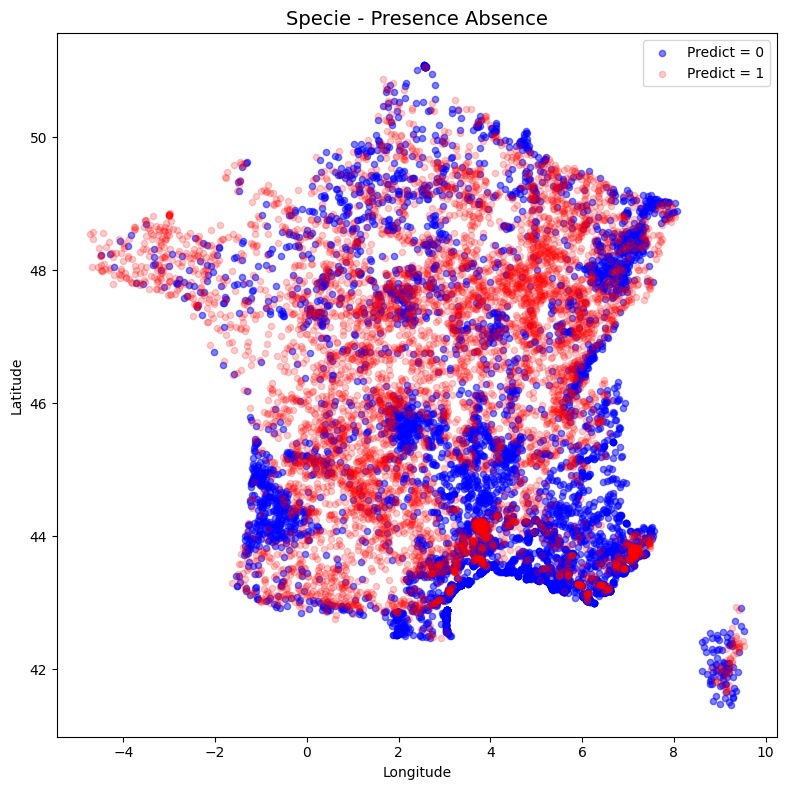

In [85]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot points where predict = 0
gdf[gdf['predict'] == 0].plot(
    ax=ax,
    color='blue',
    alpha=0.5,  # Transparency value (0-1)
    markersize=20,
    label='Predict = 0'
)

# Plot points where predict = 1
gdf[gdf['predict'] == 1].plot(
    ax=ax,
    color='red',
    alpha=0.2,  # Transparency value (0-1)
    markersize=20,
    label='Predict = 1'
)

ax.set_title('Specie - Presence Absence', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.tight_layout()
plt.show()

## Explore

In [90]:
pa["speciesId"].value_counts().head(10)

speciesId
540.0      21489
4397.0     19791
254.0      18117
4499.0     15270
10317.0    14570
2885.0     14506
1964.0     14219
10600.0    14134
10073.0    13506
11140.0    13112
Name: count, dtype: int64

In [94]:
dff = pa.loc[pa["speciesId"]==540]
print(dff.shape)
print(len(dff['surveyId'].unique()))
gdff = gpd.GeoDataFrame(dff,
                        geometry = gpd.points_from_xy(dff["lon"],
                                                     dff["lat"]),
                       crs="EPSG:4326")

(21489, 9)
21130


<Axes: >

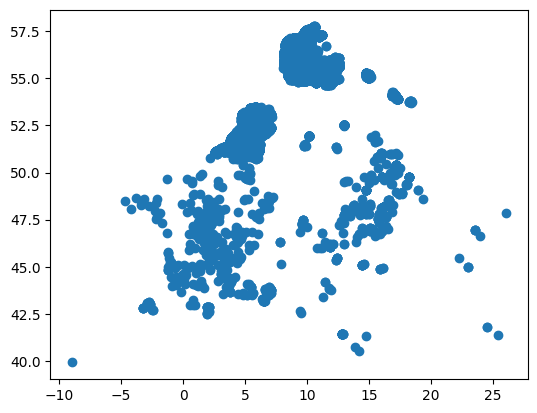

In [93]:
gdff.plot()

In [ ]:
### Joined dataset 
df1 = pd.read_parquet("/mnt/d/desktop/COPERNICUS/Classes/3-semester/ml/species/output/train_join.parquet",
                      engine="fastparquet")

In [16]:
df1.head()

,surveyId,average_Bio1,average_Bio2,average_Bio3,average_Bio4,average_Bio5,average_Bio6,average_Bio7,average_Bio8,average_Bio9,...,landcover_LandCover,soilgrids_Soilgrid-bdod,soilgrids_Soilgrid-cec,soilgrids_Soilgrid-cfvo,soilgrids_Soilgrid-clay,soilgrids_Soilgrid-nitrogen,soilgrids_Soilgrid-phh2o,soilgrids_Soilgrid-sand,soilgrids_Soilgrid-silt,soilgrids_Soilgrid-soc
0,212,2883,68,3,5545,3007,2780,227,2854,2958,...,8.0,140.0,214.0,151.0,292.0,159.0,73.0,284.0,422.0,176.0
1,222,2815,59,2,5690,2935,2720,215,2860,2768,...,12.0,120.0,225.0,101.0,94.0,379.0,58.0,650.0,255.0,609.0
2,243,2821,26,1,5150,2910,2741,169,2838,2832,...,5.0,115.0,261.0,86.0,131.0,373.0,54.0,750.0,117.0,672.0
3,324,2870,90,3,5315,2992,2756,236,2810,2938,...,14.0,118.0,179.0,117.0,225.0,230.0,57.0,238.0,535.0,302.0
4,333,2858,81,3,5285,2982,2758,224,2827,2927,...,14.0,138.0,233.0,176.0,328.0,250.0,71.0,231.0,439.0,257.0


In [59]:
df1["surveyId"].unique()

array([    212,     222,     243, ..., 3919620, 3919640, 3919655],
      shape=(88987,))

In [18]:
len(df1["surveyId"].unique())

88987

In [2]:
#climate = pd.read_csv("/mnt/d/desktop/COPERNICUS/Classes/3-semester/ml/species/output/EnvironmentalRasters/Climate/GLC24-PA-train-bioclimatic-average.csv")
climate_month = pd.read_csv("output/EnvironmentalRasters/Climate/GLC24-PA-train-bioclimatic-monthly.csv")

In [3]:
climate_month.head()

,surveyId,Bio-pr_01_2000,Bio-tas_01_2000,Bio-tasmax_01_2000,Bio-tasmin_01_2000,Bio-pr_02_2000,Bio-tas_02_2000,Bio-tasmax_02_2000,Bio-tasmin_02_2000,Bio-pr_03_2000,...,Bio-tasmax_10_2018,Bio-tasmin_10_2018,Bio-pr_11_2018,Bio-tas_11_2018,Bio-tasmax_11_2018,Bio-tasmin_11_2018,Bio-pr_12_2018,Bio-tas_12_2018,Bio-tasmax_12_2018,Bio-tasmin_12_2018
0,212,5872,2801,2828,2773,1229,2834,2860,2796,1184,...,2925,2872,7830,2862,2884,2836,4271,2839,2865,2810
1,222,4998,2765,2783,2740,6591,2769,2790,2745,6000,...,2861,2810,3787,2791,2809,2777,6133,2773,2786,2756
2,243,5387,2776,2787,2765,8123,2776,2785,2765,5518,...,2861,2837,4348,2805,2815,2795,9243,2787,2795,2776
3,324,1567,2777,2817,2739,9315,2830,2868,2780,10298,...,2927,2837,8789,2833,2879,2797,5142,2826,2861,2795
4,333,2085,2780,2810,2752,10213,2813,2845,2774,3199,...,2924,2839,9468,2824,2861,2799,13480,2818,2846,2794


In [4]:
climate_month.columns

Index(['surveyId', 'Bio-pr_01_2000', 'Bio-tas_01_2000', 'Bio-tasmax_01_2000',
       'Bio-tasmin_01_2000', 'Bio-pr_02_2000', 'Bio-tas_02_2000',
       'Bio-tasmax_02_2000', 'Bio-tasmin_02_2000', 'Bio-pr_03_2000',
       ...
       'Bio-tasmax_10_2018', 'Bio-tasmin_10_2018', 'Bio-pr_11_2018',
       'Bio-tas_11_2018', 'Bio-tasmax_11_2018', 'Bio-tasmin_11_2018',
       'Bio-pr_12_2018', 'Bio-tas_12_2018', 'Bio-tasmax_12_2018',
       'Bio-tasmin_12_2018'],
      dtype='object', length=913)

In [6]:
climatic = pd.read_csv("/mnt/d/desktop/COPERNICUS/Classes/3-semester/ml/species/output/EnvironmentalRasters/Climate/GLC24-PA-train-bioclimatic-average.csv")

In [13]:
climatic.head()

,surveyId,Bio1,Bio2,Bio3,Bio4,Bio5,Bio6,Bio7,Bio8,Bio9,...,Bio11,Bio12,Bio13,Bio14,Bio15,Bio16,Bio17,Bio18,Bio19,bio1_correct
0,212,2883,68,3,5545,3007,2780,227,2854,2958,...,2816,6355,933,143,395,2282,770,770,1917,14.8
1,222,2815,59,2,5690,2935,2720,215,2860,2768,...,2746,7286,792,376,201,2283,1336,2076,1653,8.0
2,243,2821,26,1,5150,2910,2741,169,2838,2832,...,2759,8546,1117,372,295,2986,1438,2448,1838,8.6
3,324,2870,90,3,5315,2992,2756,236,2810,2938,...,2802,10719,1163,564,197,3216,1948,1948,2926,13.5
4,333,2858,81,3,5285,2982,2758,224,2827,2927,...,2792,9353,1095,503,249,3186,1638,1638,2677,12.3


In [12]:
climatic['bio1_correct'] = climatic["Bio1"]/10-273.5

In [ ]:
climati